# 🔍 Exploring Bank Marketing Data

Our **goal** in this notebook is to find useful information (insights) that will help us accurately estimate the probability of a customer subscribing to the company's proposal for a term deposit in the bank. The target variable, `y`, is a binary variable. The data is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. More information about the data can be found [here](https://archive.ics.uci.edu/dataset/222/bank+marketing).

With that in mind, we will briefly explore the data in the following sections. We will start with data exploration, where we will try to detect patterns. After that, we will delve into data preparation, where we will transform our data into a format appropriate for machine learning algorithms. Finally, in the modeling section, we will try various machine learning classification algorithms to accurately predict whether the customer will subscribe to a term deposit.

Now, let's load all the packages that we will need to explore the data and draw conclusions from it.

In [1]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

sns.set_style("whitegrid")

***

## 📥 Getting the Data

The data we need is located in the `{project_folder}/data/raw/bank-full.csv` file. Let's upload this CSV file and take a look at the first few rows of the data using `pandas`.

In [2]:
marketing = pd.read_csv("../data/bank-full.csv", sep=';')

marketing.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


There are both categorical and numerical features in our data. Additionally, there are two date features (`day` and `month`) representing the last contact day and month. We will investigate these date features later in the exploration section. Now, let's examine the numerical and categorical features.

In [3]:
marketing.describe(include='number')

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


- There are outliers in numerical features. For example. at the 75th percentile of the `balance` feature, values are found to be below or equal to 1428. However, some values deviate significantly from this range. The maximum value for `balance` differs by nearly 100-fold from its 75th percentile counterpart.
- The numerical feature `pdays` predominantly holds a value of `-1` for over 75% of the cases. This suggests that a substantial number of clients have not been previously contacted.
- A similar trend is observed in the `previous` feature, which represents the number of contacts performed before the current campaign for a specific client.

In [4]:
marketing.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


* Categorical features have varying numbers of unique categories. For example, `job` has 12 unique categories, `marital` has 3, and `poutcome` has 4.
* The target variable `y` has two unique values, `yes` and `no`, with `no` being the most frequent outcome, occurring `39,922` times in the dataset.

Now, let's examine the technical information of our dataset using the `info` method.

In [5]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Our dataset contains `45,211` records with `17` columns. We have a mix of **numerical** and **categorical** features, and there are **no missing values** in any of the columns.

## 🌊 Data Deep Dive

Before we delve into the data, let's make a copy of our dataframe to ensure that any data transformations will not affect the original dataframe.

In [6]:
df = marketing.copy()

It is time to investigate our target variable, `y`. We will also give this variable a more informative name `subcribe` so we will not be confused by its name in our visualizations. Let's start by looking at the proportion of how many clients subscribed to a term deposit.

In [7]:
df.rename(columns={"y": "subscribe"}, inplace=True)
df.loc[:, 'subscribe'] = np.where(df['subscribe'] == 'yes', 1, 0)
df['subscribe'] = df['subscribe'].astype(int)

df['subscribe'].value_counts(normalize=True)

subscribe
0    0.883015
1    0.116985
Name: proportion, dtype: float64

It looks like we are dealing with an imbalanced dataset. We will need to take this fact into account when we model our target variable. For example, metrics such as 'accuracy' will not be appropriate to choose in this case. Just to mention, there are a lot of techniques that allow us to **oversample** (or, in contrast, **undersample**) the data. We will not use these fancy techniques because they might only provide a small increase in performance, as you might see in all kinds of articles related to those techniques. And, as mentioned earlier, in data preparation, we will work with outliers, and it will probably help us to reduce the level of imbalance in our data.

For now, let's look at how the number of subscribers (`subscribe = 1`) and opposers (`subscribe = 1`) changed over the period. Before that, we need to deal with date features to appropriately restore the information about the concrete date when the agent contacted the client for a term deposit proposal. We can do this because we know from the description of the dataset that data was collected in the period of `2008-05-05` to `2010-11-17`. We will implement the function that will restore these dates from the month and day by doing the following: we will start with the counter `start_year = 2018` and manually increase this counter whenever we see the month `January`. Also, we will drop the columns day, month, and those generated during the function, such as year, because we can restore this information from the date itself.

In [8]:
def generate_date_column(df):
    df['year'] = None

    start_year = 2008
    increment_year = False
    for idx, row in df.iterrows():
        if row['month'] == 'jan' and increment_year == False:
            start_year += 1
            increment_year = True
        elif row['month'] != 'jan':
            increment_year = False
        
        df.loc[idx, 'year'] = start_year

    df['contact_date'] = df['day'].astype(str) + df['month'].astype(str) + df['year'].astype(str)
    df['contact_date'] = pd.to_datetime(df['contact_date'], format='%d%b%Y')

    df.drop(columns=['day', 'month', 'year'], inplace=True)

    return df

df = generate_date_column(df)

df['contact_date'].min(), df['contact_date'].max()

(Timestamp('2008-05-05 00:00:00'), Timestamp('2010-11-17 00:00:00'))

Now we can extract year and month from the generated column `contact_date`, aggregate the number of `subscribers` and `opposers` for each year and month, and visualize the dynamic changes over time with `seaborn`.

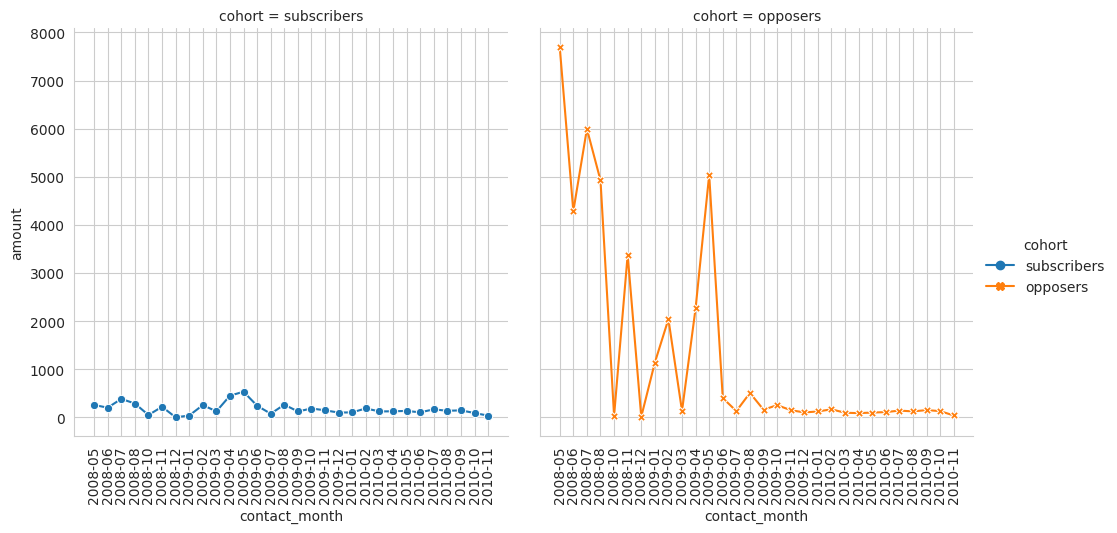

In [9]:
df['contact_month'] = df['contact_date'].dt.to_period('M')

contact_month_summary = df.groupby(by='contact_month').agg(
    subscribers=('subscribe', 'sum'), 
    calls=('subscribe', 'count')
)
contact_month_summary = contact_month_summary.reset_index()
contact_month_summary['opposers'] = contact_month_summary['calls'] - contact_month_summary['subscribers']
contact_month_summary['contact_month'] = contact_month_summary['contact_month'].dt.strftime('%Y-%m')
contact_month_summary = contact_month_summary.melt(
    id_vars=['contact_month'], value_vars=['subscribers', 'opposers'], 
    var_name='cohort', value_name='amount'
)

g = sns.relplot(
    data=contact_month_summary, x="contact_month", y="amount", 
    col="cohort", style="cohort", hue='cohort', 
    kind="line", dashes=False, markers=True
)
g.set_xticklabels(rotation=90);

As we can see from the graph above, both the number of subscribers and the number of opposers were relatively high before `2009-06`. This might be because the company was dealing with aggressive marketing and made calls to a lot of clients. After 2009-06, the numbers went down and remained at the same level.

What insights might this provide?

+ Features such as after_aggressive_marketing
+ We probably also need to include the feature "representative" for each group

Additional thoughts: If we assume that we are dealing with a time-series dataset (which may or may not be the case, since we do not know whether the company called clients several times during the marketing period), then we probably need to drop records related to the time before `2009-06`, unless the marketing department plans to implement another aggressive strategy.

Now let's investigate numerical features.

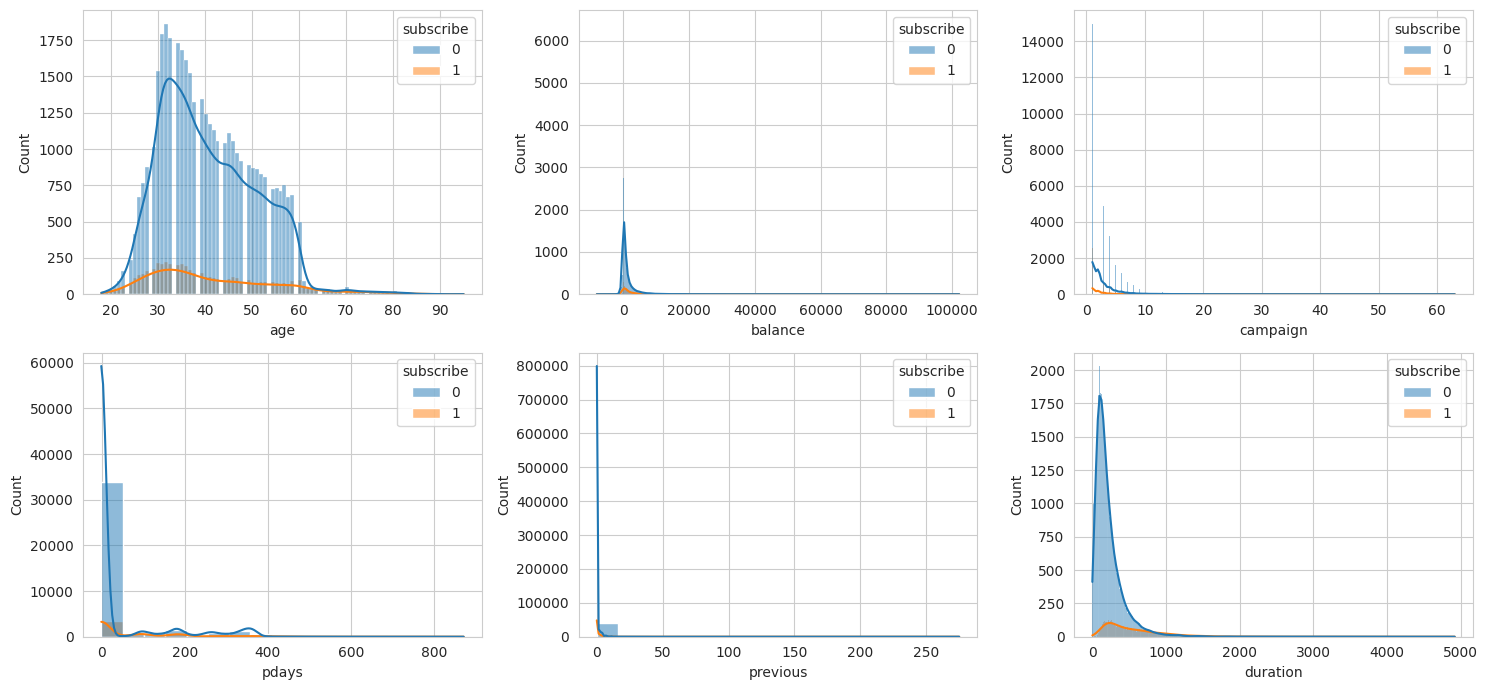

In [10]:
features = ['age', 'balance', 'campaign', 'pdays', 'previous', 'duration']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
for i, ax in enumerate(axes.flatten()):
    sns.histplot(data=df, x=features[i], hue='subscribe', kde=True, ax=ax)

plt.tight_layout()
plt.show()

The graph above illustrates the distributions of numerical features for distinct binary target values. It becomes evident that the distributions for both subscribed and rejected clients are quite similar, with the primary distinguishing factor being the degree of imbalance.

Additionally, it's worth noting that the feature `duration` is "leak-feature" as indicated by the source. We will not have access to this information for inference purposes. We can observe that if the duration equals `0`, the client tends to reject our promotion. There are more than **300** such clients, which is a relatively substantial number given the inherent imbalance in the dataset.

In [11]:
from sklearn.feature_selection import r_regression

df_pearson_corr = r_regression(df[features], df['subscribe'], force_finite=False)
df_pearson_corr = pd.Series(df_pearson_corr, index=features)
df_pearson_corr.sort_values(ascending=False)

duration    0.394521
pdays       0.103621
previous    0.093236
balance     0.052838
age         0.025155
campaign   -0.073172
dtype: float64

We utilized Pearson correlation to investigate the relationships between various features and the target variable. It seems that the coefficients suggest the absence of linear correlations between the numerical features and the target, except for `duration`, which is a leak-column.

Now let's turn our attention to categorical features.

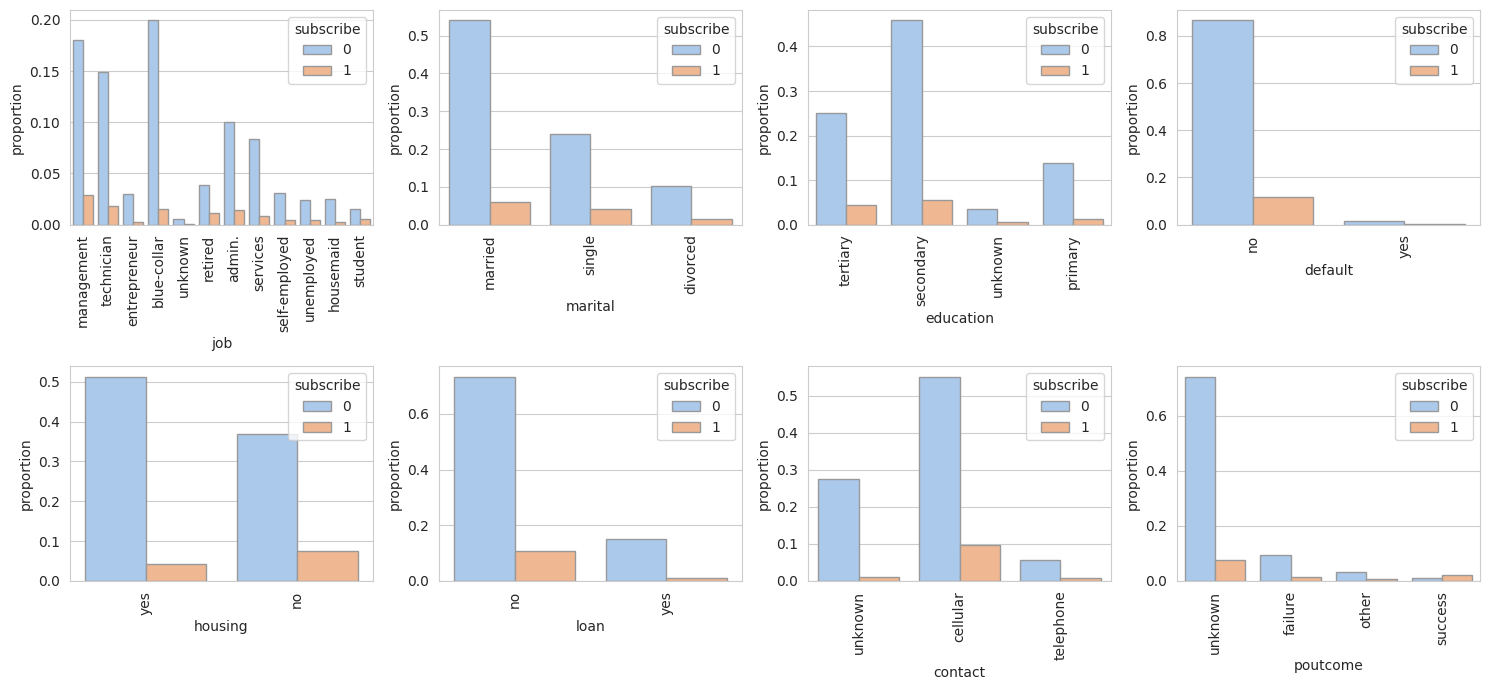

In [12]:
features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))
for i, ax in enumerate(axes.flatten()):
    sns.countplot(data=df, x=features[i], hue='subscribe', stat='proportion', palette="pastel", edgecolor=".6", ax=ax)
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

It appears that categorical variables offer more valuable insights compared to numerical ones. Analyzing the distribution of categories within each categorical feature can provide meaningful insights. 

For example, within the `poutcome` feature, a successful previous contact significantly increases the likelihood of a client subscribing to a term deposit. Conversely, when considering the `loan` feature, if a client has a loan, the chances of them not subscribing to a term deposit are notably higher.

Now let's look at Adjusted Mutual Information between categorical features and target variable.

In [13]:
from sklearn.metrics import adjusted_mutual_info_score

features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

df_mutual_info = df[features].apply(
    lambda x: adjusted_mutual_info_score(x, df['subscribe'])
)
df_mutual_info.sort_values(ascending=False)

poutcome     0.058130
contact      0.023117
housing      0.018407
job          0.006571
loan         0.006541
education    0.003466
marital      0.003268
default      0.001255
dtype: float64

An analysis of Mutual Information (MI) indicates that `poutcome`, `contact`,  and `housing` have the potential to serve as robust predictors for our target binary variable. After training the model and estimating feature importances, we will pay particular attention to these features, with a focus on `poutcome`, which has higher value, to further assess their impact.

## 🍭 Sugarcoating the Data

In [14]:
df = marketing.copy()

Let's create a convenient function for generating new features and use it on our dataset.

In [15]:
def generate_features(df):

    df['active_contact'] = (df['previous'] != 0).astype(int)
    df['without_debt'] = (df['default'] == 'no') & (df['housing'] == 'no') & (df['loan'] == 'no').astype(int)

    return df

df = generate_features(df)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,active_contact,without_debt
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,0,False
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,0,False
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,0,False
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,0,False
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,0,True


Before splitting the dataset into two training and testing sets and creating pipelines for data preprocessing, let's explicitly list the numerical and categorical features, along with target feature.

*Remember:* According to the source, the numerical feature `duration` is a leak feature, so we must exclude this feature.

In [16]:
target_column = 'y'

num_features = ['age', 'balance', 'campaign', 'pdays', 'previous']
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'active_contact', 'without_debt']

We will split the dataset into the following proportions: 60% of observations will be allocated to the training set, 20% for validation, and the remaining 20% for testing. Additionally, let's shuffle the dataset and fix the random state.

In [17]:
df_train_full, df_test = train_test_split(
    df[num_features + cat_features + [target_column]], test_size=0.2, 
    stratify=df[target_column], shuffle=True, random_state=42
)

df_train, df_valid = train_test_split(
    df_train_full[num_features + cat_features + [target_column]], test_size=0.25, 
    stratify=df_train_full[target_column], shuffle=True, random_state=42
)

We are now ready to establish a preprocessing pipeline. Within this pipeline, we will standardize the numerical features using the `StandardScaler`, while the categorical features will be encoded using the `OneHotEncoder`.

In [18]:
ct = ColumnTransformer([
    ("num_preprocess", StandardScaler(), num_features),
    ("cat_preprocess", OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False), cat_features)
])

X_train_full, y_train_full = ct.fit_transform(df_train_full), (df_train_full[target_column] == 'yes').astype(int).values
X_test, y_test = ct.transform(df_test), (df_test[target_column] == 'yes').astype(int).values

X_train, y_train = ct.fit_transform(df_train), (df_train[target_column] == 'yes').astype(int).values
X_valid, y_valid = ct.fit_transform(df_valid), (df_valid[target_column] == 'yes').astype(int).values

Everything is progressing smoothly up to this point. Now, let's delve into the most captivating aspect of our analysis: training machine learning algorithms and assessing performance metrics.

## ⚙️ Model Building Hub

We will conduct fine-tuning utilizing the `optuna` package, an open-source hyperparameter optimization framework that streamlines hyperparameter search. An illustrative example of fine-tuning scikit-learn models can be found [here](https://github.com/optuna/optuna-examples/blob/main/sklearn/sklearn_simple.py).

In essence, our process involves defining an `objective` function responsible for metric calculation and return. Subsequently, we configure a `study` and specify the direction argument to indicate whether we seek to maximize or minimize the metric. The optimization process is then initiated using the `optimize` method.

`Optuna` is a powerful and efficient library that enables us to explore numerous combinations of hyperparameters within a reasonable timeframe.

In [19]:
def objective(trial):

    classifier_name = trial.suggest_categorical(
        "classifier", ["LogisticRegression", "RandomForest", "XGBoost"]
    )
    if classifier_name == 'LogisticRegression':
        lr_C = trial.suggest_float("C", 0.001, 100)
        lr_class_weight = trial.suggest_categorical("class_weight_1", ["balanced", None])
        
        classifier_obj = LogisticRegression(
            C=lr_C,
            class_weight=lr_class_weight,
            
            max_iter=1000,
            random_state=42
        )
    elif classifier_name == "RandomForest":
        rf_n_estimators = trial.suggest_int("n_estimators", 20, 400)
        rf_depth = trial.suggest_int("max_depth", 1, 5)
        rf_min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
        rf_min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 20)

        classifier_obj = RandomForestClassifier(
            n_estimators=rf_n_estimators,
            max_depth=rf_depth,
            min_samples_split=rf_min_samples_split,
            min_samples_leaf=rf_min_samples_leaf,
            
            random_state=42
        )
    elif classifier_name == 'XGBoost':
        xgb_n_estimators = trial.suggest_int("n_estimators", 20, 400)
        xgb_max_depth = trial.suggest_int("max_depth", 1, 16)
        xgb_learning_rate = trial.suggest_float("learning_rate", 0.001, 0.5)
        xgb_min_child_weight = trial.suggest_int("min_child_weight", 1, 8)
        
        classifier_obj = XGBClassifier(
            n_estimators=xgb_n_estimators,
            max_depth=xgb_max_depth,
            learning_rate=xgb_learning_rate,
            min_child_weight=xgb_min_child_weight,
            
            random_state=42
        )

    classifier_obj.fit(X_train, y_train)
    y_pred = classifier_obj.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, y_pred)
    return score

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print(f"Best AUC-ROC score on validation set: {study.best_trial.values}")
print(f"Best parameters: \n{study.best_params}")

Best AUC-ROC score on validation set: [0.77328001939607]
Best parameters: 
{'classifier': 'XGBoost', 'n_estimators': 267, 'max_depth': 1, 'learning_rate': 0.41850597186514554, 'min_child_weight': 8}


Now, let's take the best parameters that optuna has identified and apply them to the best classifier discovered through the optuna optimization process. In our case, the top-performing classifier happens to be `XGBoost`.

In [21]:
best_params = study.best_params
del best_params['classifier']

model = XGBClassifier(**best_params)
model.fit(X_train_full, y_train_full)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.41850597186514554,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=267, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Before evaluating our model on the testing set, let's delve into the exploration of feature importance – understanding how each feature contributes to the predictions.

In [22]:
df_feature_importances = pd.DataFrame(zip(ct.get_feature_names_out(), model.feature_importances_))
df_feature_importances.columns = ['feature', 'importance']
df_feature_importances.sort_values(by='importance', ascending=False, inplace=True)
df_feature_importances.head(10)

,feature,importance
32,cat_preprocess__poutcome_success,0.545511
29,cat_preprocess__contact_unknown,0.173160
35,cat_preprocess__without_debt_True,0.162633
18,cat_preprocess__marital_married,0.027217
0,num_preprocess__age,0.023726
2,num_preprocess__campaign,0.013254
22,cat_preprocess__education_tertiary,0.009762
27,cat_preprocess__contact_cellular,0.007288
4,num_preprocess__previous,0.006415
1,num_preprocess__balance,0.005943


Analysis of feature importance highlights that `poutcome_success` (indicating the success of the previous marketing campaign) and `contact_unknown` (representing uncertainty in the method of customer contact) are the most influential factors in our model. Notably, a manually created feature, `without_debt_True`, plays a substantial role, underscoring the significance of a client's debt status as a predictor. In contrast, the remaining features have comparatively minor impacts on the model's predictions.

Finally, it's time to evaluate the model's performance on the test set that was initially established to ensure that everything is functioning as expected.

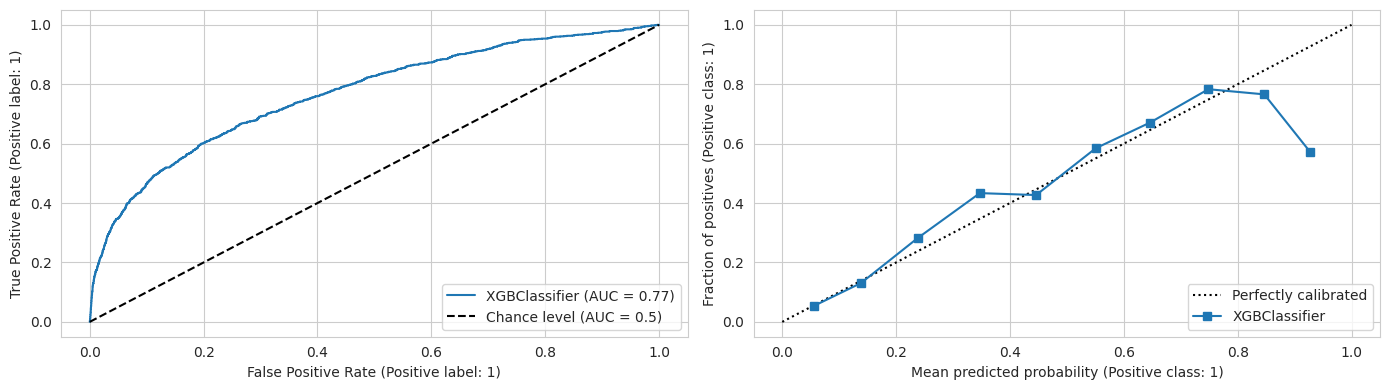

In [23]:
def create_visual_report(clf, X, y):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

    RocCurveDisplay.from_estimator(clf, X, y, plot_chance_level=True, ax=axes[0])
    CalibrationDisplay.from_estimator(clf, X, y, n_bins=10, ax=axes[1])

    plt.tight_layout()
    plt.show()

create_visual_report(model, X_test, y_test)

The results appear to be favorable and in line with our expectations. The model is also well-calibrated, indicating that we can interpret the probabilities generated by the model as accurate representations of real probabilities.